In [5]:
#setup
import matplotlib.pyplot as plt
import urllib2
%matplotlib inline

In [ ]:
import os
import subprocess as sp
import numpy
import select
import sys

#set up ffmpeg
FFMPEG_BIN = "ffmpeg"
video = '556.mp4'
width = 1920
height = 1080
command = [ FFMPEG_BIN,
            '-i', video,
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-']
pipe = sp.Popen(command, stdout = sp.PIPE, bufsize=10**8)

#return red value from each frame
def captureFrame():
    # read 1920*1080*3 bytes (= 1 frame)
    raw_image = pipe.stdout.read(width*height*3)
    # transform the byte read into a numpy array
    image =  numpy.fromstring(raw_image, dtype='uint8')
    frameTotalByteSize = width*height*3
    if len(image) < frameTotalByteSize:
        return False
    image = image.reshape((width,height,3))
    # throw away the data in the pipe's buffer.
    pipe.stdout.flush()
    totalRed = 0
    for col in range(0, width):
        for row in range(0, height):
            totalRed += image[col][row][0]
    return totalRed/1.0/width/height

print 'Loading the video'
rValueList = list()
while True:
    r = captureFrame()
    if not r:
        break
    else:
        rValueList.append(r)
    print r
print 'finished'

In [5]:
file = open('temp', 'w')
numpy.savetxt(file, rValueList)

In [16]:
#debug purpose only
file = open('temp', 'r')
rValueList = file.read();
rValueList = rValueList.split('\n')
rValueList =  rValueList[0:len(rValueList)-1]
rValueList = [float(red) for red in rValueList]

In [17]:
#obtain rr intervals from red value
def constructRRListFromRedValueList(redValueList, fps):
    timePerFrame = 1.0/fps
    rrList = list()
    lastMaxIndex = False
    for i in range(1, len(redValueList)-1):
        previousSlope = redValueList[i] - redValueList[i-1]
        afterSlope = redValueList[i+1] - redValueList[i]
        # if at that point it is concave down = local max
        if previousSlope*afterSlope < 0 and previousSlope > 0:
            if lastMaxIndex:
                rrInterval = (i-lastMaxIndex)*timePerFrame
                rrList.append(rrInterval)
            lastMaxIndex = i
    return rrList
rrList = constructRRListFromRedValueList(rValueList, 30.0)

Total Video Time:  29.3666666667
RR Interval List:  [1.0, 0.3333333333333333, 0.5666666666666667, 0.3333333333333333, 0.5333333333333333, 0.9, 0.9333333333333333, 0.36666666666666664, 0.5, 0.9, 0.9333333333333333, 1.0333333333333332, 0.36666666666666664, 0.6, 0.3333333333333333, 0.5333333333333333, 0.36666666666666664, 0.6333333333333333, 1.0, 0.36666666666666664, 0.6, 0.3333333333333333, 0.5666666666666667, 0.36666666666666664, 0.5666666666666667, 0.36666666666666664, 0.6, 1.0, 0.3333333333333333, 0.5666666666666667, 0.3, 0.5666666666666667, 0.9333333333333333, 1.0, 1.0333333333333332, 0.3, 0.5666666666666667, 0.3333333333333333, 0.6333333333333333, 1.0333333333333332, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.6, 0.36666666666666664, 0.6333333333333333, 0.2, 0.16666666666666666, 0.6, 0.36666666666666664, 0.5666666666666667]


Time List:  [1.0, 1.3333333333333333, 1.9, 2.2333333333333334, 2.7666666666666666, 3.6666666666666665, 4.6, 4.966666666666666, 5.466666666666

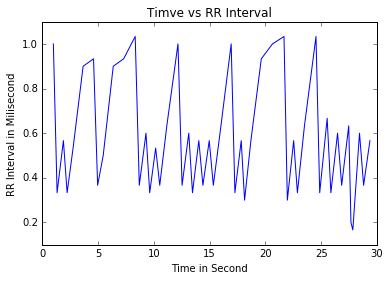

In [18]:
def constructTimeListFromRRList(rrList, beginT, endT):
    #construct time array from the rr intervals
    tList = list()
    tList.append(float(rrList[0]))
    for i in range(1, len(rrList)):
        tList.append(tList[len(tList)-1] + float(rrList[i]))
    if tList[len(tList)-1]<endT:
        endT=tList[len(tList)-1]

    #limit the time interval
    beginIndex = 0
    endIndex = 0
    i = 0
    while tList[i]<beginT:
        i+=1
    beginIndex = i
    while tList[i]<endT:
        i+=1
    endIndex = i
    tList = tList[beginIndex: endIndex]
    rrList = rrList[beginIndex: endIndex]
    return tList, rrList

def plot(tList, rrList):
    #plotting the graph
    plt.plot(tList, rrList)
    plt.xlabel('Time in Second')
    plt.ylabel('RR Interval in Milisecond')
    plt.title('Timve vs RR Interval')
    plt.show()
tList, rrList = constructTimeListFromRRList(rrList, 0, 50)
total =0
for r in rrList:
    total+=r
print 'Total Video Time: ', total
print 'RR Interval List: ', rrList

print '\n'
print 'Time List: ', tList
plot(tList, rrList)